## 语义分割
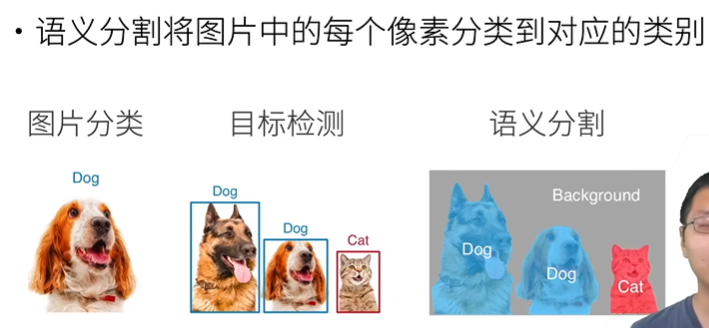

## 应用场景1：背景虚化
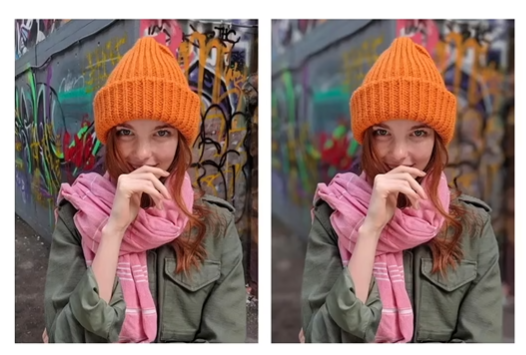

## 应用场景2：路面分割
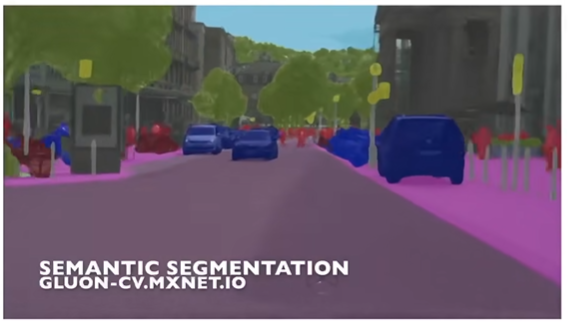

## 语义分割 VS 实例分割
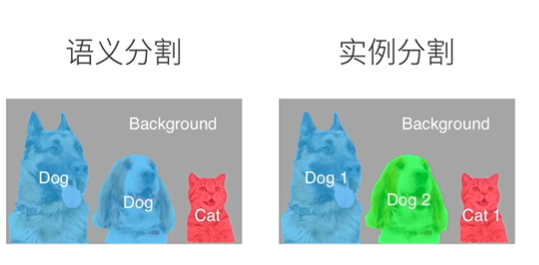

## Pascal VOC2012 语义分割数据集
语义分割领域最重要的数据集之一

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

数据集中标签也采用图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """
    将所有VOC中的图像和标签读入内存
    """
    # 存放待读入内存的图像文件名的txt文件所在的路径
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    
    # 需要读入内存的图像的文件名（不包含扩展名）
    with open(txt_fname, 'r') as f:
        images = f.read().split() # images = ['xxx1', 'xxx2', 'xxx3']
    
    # 读入图片（张量形式）
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
            ))
        labels.append(torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png')
            , mode))
        
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, is_train=True)

绘制前五个样本及其标签，在标签图像中，黑色代表背景，白色代表边框，其他颜色代表不同的类别

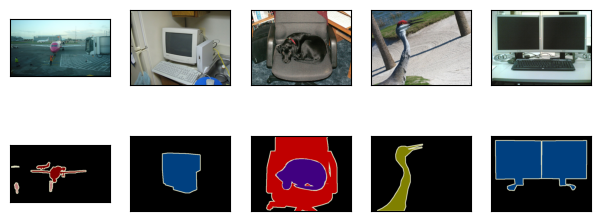

In [4]:
n = 5
imgs = train_features[:n] + train_labels[:n]
# 画图时要把channel维放到最后
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);

在VOC数据集中，标签图片中的RGB值（三元组）和类别名的对应关系如下

In [5]:
# 标签图片中的RGB值
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

# RGB值对应的类别名
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
def voc_colormap2label():
    """构建VOC数据集中标签图片的RGB值到类别索引的映射"""
    # 初始化一个一维tensor
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    
    # 将RGB值进行一系列计算后的结果作为索引
    # 通过该索引在数组中找到该RGB值对应的类别索引
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    
    return colormap2label

def voc_label_indices(colormap, # 彩色图片
                      colormap2label):
    """
    将RGB标签图片的每个像素映射成类别索引
    """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    
    # 返回该标签图片每个像素对应的类别索引
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

我们显示第一张样本图像中飞机头部分，飞机的类别索引为1，而背景索引为0。

In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

## 预处理数据
语义分割中不能通过使用Resize缩放图片来统一图片尺寸，会导致映射不够精准，为了避免这个问题，我们对图像裁剪成固定尺寸，而不再是缩放（特征图片和标签图片都要经历相同的裁剪）

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

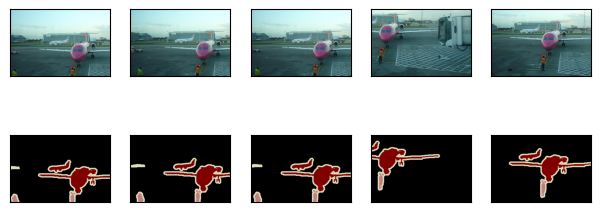

In [8]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像成固定尺寸"""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    # 特征图片和标签图片要经历相同的裁剪
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

## 自定义语义分割数据集类
通过实现__getitem__函数，我们可以任意访问数据集中索引为idx的输入图像及其每个像素的类别索引

In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        # 过滤出能够裁剪成相同尺寸的图片
        self.features = [self.normalize_image(feature) 
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        # VOC数据集中RGB值与类别索引的映射
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(features)) + ' examples')  
    
    def normalize_image(self, img):
        """归一化像素值"""
        return self.transform(img.float() / 255)
    
    def filter(self, imgs):
        """过滤出尺寸足够裁剪的图片"""
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                      *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

## 读取数据集

In [ ]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1464 examples


In [12]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, 
                                         batch_size, 
                                         shuffle=True,
                                         drop_last=True)

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


## 整合所有组件，完成加载VOC数据集的代码

In [13]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter